In [ ]:
# !wget http://nlp.stanford.edu/data/glove.6B.zip
# !unzip -q glove.6B.zip


In [1]:
import glob
import os
print(os.getcwd())
print(*glob.glob(os.getcwd()+'/**/*',recursive=True),sep='\n')

print(*glob.glob('/kaggle/input/**/*',recursive=True),sep='\n')


/kaggle/working
/kaggle/working/__notebook_source__.ipynb
/kaggle/working/glove.6B.50d.txt
/kaggle/working/glove.6B.200d.txt
/kaggle/working/glove.6B.zip
/kaggle/working/glove.6B.100d.txt
/kaggle/working/glove.6B.300d.txt
/kaggle/input/200000-jeopardy-questions
/kaggle/input/200000-jeopardy-questions/JEOPARDY_CSV.csv


In [2]:
import pandas as pd
import numpy as np
import re
import multiprocessing as mp
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

from sklearn.preprocessing import KBinsDiscretizer,MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

import nltk
from nltk.stem import WordNetLemmatizer
import nltk
from nltk.corpus import stopwords

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tqdm.pandas()
print(tf.__version__)
# print(stopwords.words('english'))


2.4.1


/opt/conda/lib/python3.7/site-packages/tqdm/std.py:701: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [3]:
ls

__notebook_source__.ipynb  glove.6B.200d.txt  glove.6B.50d.txt
glove.6B.100d.txt          glove.6B.300d.txt  glove.6B.zip


In [4]:
path_to_glove_file="/kaggle/working/glove.6B.100d.txt"
embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found word vectors:",len(embeddings_index))

Found word vectors: 400000


In [5]:
def embedding(words,max_len):
    result=[]
    for i in words:
        vec=embeddings_index.get(word)
        if vec is None:
            vec=np.zeros(100)
        result.append(vec)
    result1=np.array(result)
    l=result1.shape[0]
    if len(result1)==0:
        return np.zeros(100)
    if max_len is None:
        return result1.mean(axis=0)
    if l<max_len:
        result1=np.vstack((result1,np.zeros((max_len-l,100))))
    return result1.mean(axis=0)


def embedding_batch(sentences_list,max_len=136):
    result=np.vstack([embedding(sentence.split(' '),max_len) for sentence in sentences_list])
    return result

In [6]:
allowed_char="0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ "
wordnet_lemmatizer = WordNetLemmatizer()
stop_words=set(stopwords.words('english'))
def lemmetize_fn(x):
	x1=re.sub(f"[^{allowed_char}]"," ",x).lower()
	x2=nltk.word_tokenize(x1)
	x2=[i for i in x2 if (i not in stop_words)]
	return " ".join([wordnet_lemmatizer.lemmatize(i, pos="v") for i in x2])


df=pd.read_csv("/kaggle/input/200000-jeopardy-questions/JEOPARDY_CSV.csv")
df=df[df[' Value']!='None'].reset_index(drop=True)

In [7]:
with mp.Pool(16) as pool:
    df['lem_words']=pool.map(lemmetize_fn,tqdm(df[' Question']))

df=df[df['lem_words'].apply(lambda x:len(x))>0]

emb_split=np.array_split(df['lem_words'].to_numpy(),8)
with mp.Pool() as pool:
    x=np.vstack(pool.map(embedding_batch,tqdm(emb_split)))

  0%|          | 0/213296 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

In [8]:
def discritizer_costum(y):
    boundary=[200,300,400,500,600,800,1000,1500,2000]
    counter=0
    for i in boundary:
        if y<i:
            return counter
        counter+=1
    return counter

df['value']=df[' Value'].apply(lambda x:int(re.sub(r'\D','',x)))

df['value1']=df['value'].apply(discritizer_costum)
display(df.groupby('value1').agg({'value':['min','max','size']}))
y=df['value1'].to_numpy()


# df['value1']=np.log10(df['value']).astype(np.int64)
# display(df.groupby('value1').agg({'value':['min','max','size']}))

# kbin=KBinsDiscretizer(n_bins=10, encode='onehot-dense', strategy='quantile') #uniform
# kbin.fit(df[['value']].to_numpy())
# y=kbin.transform(df[['value']])


value              
         min    max   size
value1                    
0          5    100   9039
1        200    250  30456
2        300    367   8663
3        400    400  42240
4        500    585   9017
5        600    796  20584
6        800    900  31969
7       1000   1492  33785
8       1500   1900  11844
9       2000  18000  15673

In [9]:
print(x.shape,y.shape)
print(max(len(i) for i in df['lem_words']))

(213270, 100) (213270,)
677


# machine learning model

In [11]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.3)
print(x_train.shape,y_train.shape,x_test.shape,y_test.shape)

rf=RandomForestClassifier(n_estimators=100,max_depth=10,n_jobs=-1,verbose=0)
rf.fit(x_train,y_train)
pred=rf.predict(x_test)

print("random forest model performance:",rf.score(x_test,y_test))

NB = GaussianNB()
NB.fit(x_train,y_train)
pred=NB.predict(x_test)

print("naive bayes model performance:",NB.score(x_test,y_test))


(149289, 100) (149289,) (63981, 100) (63981,)
random forest model performance: 0.20085650427470655
naive bayes model performance: 0.06906737937825291


# deep learning model

In [13]:
train,test=train_test_split(df,test_size=0.3)
y_train=tf.keras.utils.to_categorical(train['value1'].to_numpy(), num_classes=10, dtype='int')
y_test=tf.keras.utils.to_categorical(test['value1'].to_numpy(), num_classes=10, dtype='int')

tokenizer = Tokenizer(num_words=136,oov_token='oov')
tokenizer.fit_on_texts(train['lem_words'])
print('total unique tokens:',len(tokenizer.word_index))

x_train=pad_sequences(tokenizer.texts_to_sequences(train['lem_words']), maxlen=136)
x_test=pad_sequences(tokenizer.texts_to_sequences(test['lem_words']), maxlen=136)


total unique tokens: 65911


In [14]:
print(x_train.shape,y_train.shape,x_test.shape,y_test.shape)

(149289, 136) (149289, 10) (63981, 136) (63981, 10)


In [15]:
embedding_matrix = np.zeros((len(tokenizer.word_index) + 1, 100))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [17]:
embedding_matrix.shape

(65912, 100)

In [18]:
inputs=tf.keras.layers.Input(shape=(136,))
layer=tf.keras.layers.Embedding(input_dim=len(embedding_matrix),
                          output_dim=100,weights=[embedding_matrix],
                          input_length=136,trainable=False)(inputs)
# ,weights=[embedding_matrix],
layer = tf.keras.layers.LSTM(100)(layer)
outputs = tf.keras.layers.Dense(10,activation='softmax')(layer)
model = tf.keras.models.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer="rmsprop", loss="categorical_crossentropy", metrics=["accuracy"])
model.summary()


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 136)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 136, 100)          6591200   
_________________________________________________________________
lstm (LSTM)                  (None, 100)               80400     
_________________________________________________________________
dense (Dense)                (None, 10)                1010      
Total params: 6,672,610
Trainable params: 81,410
Non-trainable params: 6,591,200
_________________________________________________________________


In [19]:
ES=tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
history=model.fit(x_train,y_train,epochs=50,batch_size=64,validation_data=(x_test, y_test),callbacks=[ES])

Epoch 1/50
2333/2333 [==============================] - 30s 12ms/step - loss: 2.1489 - accuracy: 0.1923 - val_loss: 2.1325 - val_accuracy: 0.2032
Epoch 2/50
2333/2333 [==============================] - 27s 12ms/step - loss: 2.1287 - accuracy: 0.2006 - val_loss: 2.1261 - val_accuracy: 0.2044
Epoch 3/50
2333/2333 [==============================] - 27s 12ms/step - loss: 2.1236 - accuracy: 0.2037 - val_loss: 2.1255 - val_accuracy: 0.2046
Epoch 4/50
2333/2333 [==============================] - 27s 12ms/step - loss: 2.1225 - accuracy: 0.2052 - val_loss: 2.1234 - val_accuracy: 0.2055
Epoch 5/50
2333/2333 [==============================] - 27s 12ms/step - loss: 2.1191 - accuracy: 0.2036 - val_loss: 2.1240 - val_accuracy: 0.2040
Epoch 6/50
2333/2333 [==============================] - 28s 12ms/step - loss: 2.1176 - accuracy: 0.2045 - val_loss: 2.1225 - val_accuracy: 0.2067
Epoch 7/50
2333/2333 [==============================] - 27s 12ms/step - loss: 2.1123 - accuracy: 0.2093 - val_loss: 2.1239 -

In [20]:
print("loss,accuracy:",model.evaluate(x_test,y_test,verbose=0))


loss,accuracy: [2.1224777698516846, 0.20670199394226074]


In [21]:
pred=model.predict(x_test)
p1=np.argmax(pred,axis=1)
y1=np.argmax(y_test,axis=1)
accuracy=(p1==y1).sum()/len(p1)
print('accuracy:',accuracy)

accuracy: 0.2067019896531783


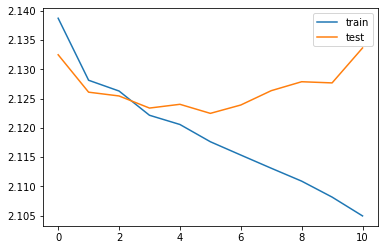

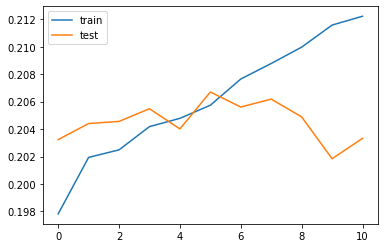

In [22]:
plt.plot(history.history['loss'],label='train')
plt.plot(history.history['val_loss'],label='test')
plt.legend()
plt.show()

plt.plot(history.history['accuracy'],label='train')
plt.plot(history.history['val_accuracy'],label='test')
plt.legend()
plt.show()